In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import seaborn as sns
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random as rnd

In [8]:
df=pd.read_hdf('256-_16.h5')

/home/deshpande.u/.conda/envs/upendra/lib/python3.9/site-packages/pandas/io/pytables.py:3007: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  index = factory(


In [9]:
df_train=df[df.data=='train']
X_train= df_train.drop(['data','class'], axis=1).to_numpy()
Y_train= df_train['class'].replace(0,-1).to_numpy()
df_val = df[df.data=='valid']
X_val= df_val.drop(['data','class'], axis=1).to_numpy()
Y_val= df_val['class'].replace(0,-1).to_numpy()
df_test = df[df.data=='test']
X_test= df_test.drop(['data','class'], axis=1).to_numpy()
Y_test= df_test['class'].replace(0,-1).to_numpy()

In [10]:
class SVM():
    def __init__(self, max_iter=100, kernel_type='linear', C=1.0, epsilon=0.001):
        self.kernels = {
            'linear' : self.kernel_linear,
            'quadratic' : self.kernel_quadratic,
            'rbf' : self.kernel_rbf
        }
        self.max_iter = max_iter
        self.kernel_type = kernel_type
        self.C = C
        self.epsilon = epsilon
        
    def fit(self, X, y,X_val,Y_val):
        n, d = X.shape[0], X.shape[1]
        alpha = np.zeros((n))
        kernel = self.kernels[self.kernel_type]
        count = 0
        f1_train = []
        f1_val = []
        max_f1 = -1.0
        while True:
            count += 1
            m=50
            alpha_prev = np.copy(alpha)
            for j in range(0, n):
                i = self.get_rnd_int(0, n-1, j) # Get random int i~=j
                x_i, x_j, y_i, y_j = X[i,:], X[j,:], y[i], y[j]
                k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
                if k_ij == 0:
                    continue
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                (L, H) = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                # Compute model parameters
                self.w = self.calc_w(alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                # Compute E_i, E_j
                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)
               
                # Set new alpha values
                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)

                alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])
                
            f1_train.append(self.predict_f1(X,y))
            f1_val.append(self.predict_f1(X_val,Y_val))
            alpha_idx = np.where(alpha > 0)[0]
            support_vectors = X[alpha_idx, :]
            
            # Check convergence            
            diff = np.linalg.norm(alpha - alpha_prev)
            if diff < self.epsilon:
                break
            
            if count >= self.max_iter:
                print("Iteration number exceeded the max of %d iterations" % (self.max_iter))
                
                return f1_train, f1_val, support_vectors
        self.b = self.calc_b(X, y, self.w)
        if self.kernel_type == 'linear':
            self.w = self.calc_w(alpha, y, X)
        # Get support vectors
        alpha_idx = np.where(alpha > 0)[0]
        support_vectors = X[alpha_idx, :]
        return f1_train, f1_val,support_vectors
    def predict_f1(self, X,y):
        y_pred = self.predict(X)
        return f1_score(y,y_pred)
        
    def predict(self, X):
        return self.h(X, self.w, self.b)
    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)
    def calc_w(self, alpha, y, X):
        return np.dot(X.T, np.multiply(alpha,y))
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k
    def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))
    def get_rnd_int(self, a,b,z):
        i = z
        cnt=0
        while i == z and cnt<1000:
            i = rnd.randint(a,b)
            cnt=cnt+1
        return i
    def kernel_linear(self, x1, x2):
        return np.dot(x1, x2.T)
    def kernel_quadratic(self, x1, x2):
        return (np.dot(x1, x2.T) ** 2)
    def kernel_rbf(self,x1, x2):
        sigma= np.std(x2)
        return np.exp(- (np.linalg.norm(x1 - x2, 2)) ** 2 / (2 * sigma ** 2))
    def predict_proba(self, X):
        return np.dot(self.w.T, X.T) + self.b


### For RBF Kernel

In [11]:
c=[]
bestf1train=[]
bestf1val=[]
for i in  [100,105,106,107,108,109,110]:
    model = SVM(max_iter=100, kernel_type='rbf', C= i , epsilon=0.00001)
    f1_train_rbf, f1_val_rbf, support_vector_rbf=model.fit(X_train, Y_train,X_val,Y_val)
    print('best f1_val for RBF kernel:',max(f1_val_rbf),
         'when C=', i)
    c.append(i) 
    bestf1train.append(max(f1_train_rbf))
    bestf1val.append(max(f1_val_rbf))

Iteration number exceeded the max of 100 iterations
best f1_val for RBF kernel: 0.8153409090909091 when C= 100
Iteration number exceeded the max of 100 iterations
best f1_val for RBF kernel: 0.8148148148148148 when C= 105
Iteration number exceeded the max of 100 iterations
best f1_val for RBF kernel: 0.8193456614509247 when C= 106
Iteration number exceeded the max of 100 iterations
best f1_val for RBF kernel: 0.8159771754636235 when C= 107
Iteration number exceeded the max of 100 iterations
best f1_val for RBF kernel: 0.8153409090909091 when C= 108
Iteration number exceeded the max of 100 iterations
best f1_val for RBF kernel: 0.8205128205128206 when C= 109
Iteration number exceeded the max of 100 iterations
best f1_val for RBF kernel: 0.8153409090909091 when C= 110


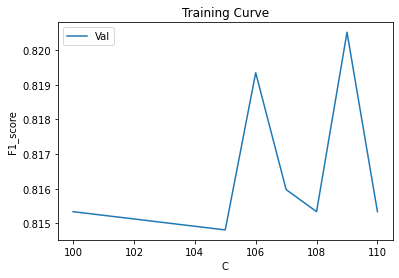

In [12]:
plt.title("Training Curve")
plt.plot(c, bestf1val, label="Val")
plt.xlabel("C")
plt.ylabel("F1_score")
plt.legend()
plt.show()

In [13]:
i=bestf1val.index(max(bestf1val))
best_c= c[i]
best_c

109

### For Best C we will run our model and plot the F1 Score

In [14]:
model = SVM(max_iter=1000, kernel_type='rbf', C= best_c , epsilon=0.0001)
f1_train_rbf, f1_val_rbf, support_vector_rbf=model.fit(X_train, Y_train,X_val,Y_val)


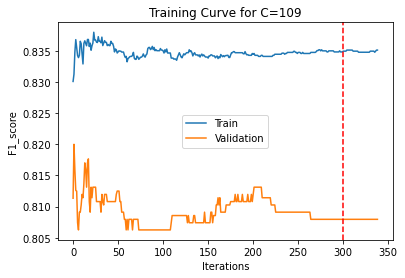

In [15]:
plt.title(f"Training Curve for C={best_c}" )
plt.plot(np.arange(len(f1_train_rbf)),f1_train_rbf , label="Train")
plt.plot(np.arange(len(f1_val_rbf)),f1_val_rbf , label="Validation")

plt.xlabel("Iterations")
plt.ylabel("F1_score")
plt.legend()
plt.axvline(x=300, color='r', linestyle='--')
plt.show()

### For Quadratic Kernel

In [16]:
model = SVM(max_iter=1000, kernel_type='quadratic', C= best_c , epsilon=0.0001)
f1_train_rbf, f1_val_rbf, support_vector_rbf=model.fit(X_train, Y_train,X_val,Y_val)

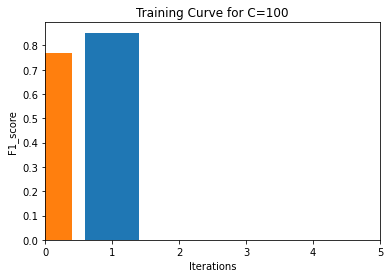

In [21]:
plt.title("Training Curve for C=100")
plt.bar(len(f1_train_rbf),f1_train_rbf , label="Train")
plt.bar(np.arange(len(f1_val_rbf)),f1_val_rbf , label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1_score")
plt.xlim(0,5)
plt.show()